In [1]:
import os, sys

import matplotlib.pyplot as plt
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import numpy as np
from scipy.spatial import distance_matrix
from src.aco_two_opt import Colony
from src.graph import Graph

In [2]:
def read_tsp_file(file_path: str) -> np.ndarray:
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        num_cities = int(lines[0])
        coords = []
        for line in lines[1:num_cities+1]:
            x, y = map(float, line.split())
            coords.append([x, y])
        
        return np.array(coords)



In [5]:
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from src.graph import Graph
from src.output import Output

def run_experiment(aco_type: str, generations: int = 100):
    coords = read_tsp_file('../data/tsp_51_1')
    graph = Graph(distance_matrix=distance_matrix(coords, coords), points=coords, eval_nn=True)
    aco = Colony(
        graph=graph,
        ant_count=50,
        generations=generations,
        type=aco_type,
        top=5,
        alpha=1,
        beta=2,
        rho=0.1,
        q0=0.9,
        phi=0.1
    )
    output: Output = aco.run()
    return output.history


types = ['as', 'eas', 'as_rank', 'mmas', 'acs']
histories = {t: run_experiment(t, generations=5000) for t in types}




50 / 51
0 463.30898809300146
1 463.30898809300146
2 459.0704367291185
3 442.59772375259365
4 442.59772375259365
5 442.59772375259365
6 442.5977237525936
7 432.5745118660963
8 432.5745118660963
9 432.5745118660963
10 432.5745118660963
11 432.57451186609626
12 432.57451186609626
13 432.57451186609626
14 432.57451186609626
15 432.57451186609626
16 432.57451186609626
17 432.57451186609626
18 432.57451186609626
19 432.57451186609626
20 432.57451186609626
21 432.57451186609626
22 432.57451186609626
23 432.57451186609626
24 432.57451186609626
25 432.57451186609626
26 432.57451186609626
27 432.57451186609626
28 432.57451186609626
29 432.57451186609626
30 432.57451186609626
31 432.57451186609626
32 432.57451186609626
33 432.57451186609626
34 432.57451186609626
35 432.57451186609626
36 432.57451186609626
37 432.57451186609626
38 432.57451186609626
39 432.57451186609626
40 432.57451186609626
41 432.57451186609626
42 432.57451186609626
43 432.57451186609626
44 432.57451186609626
45 432.57451186609

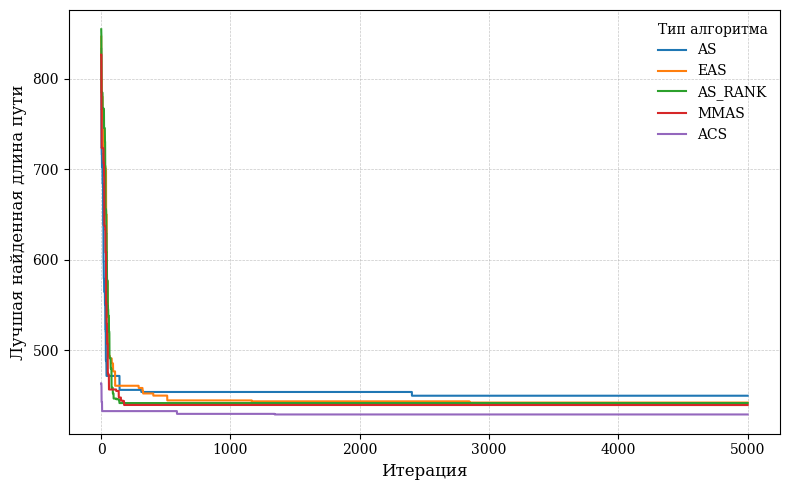

In [6]:
plt.style.use('default')
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')

for algo_type, history in histories.items():
    ax.plot(
        range(1, len(history) + 1),
        history,
        label=algo_type.upper(),
        linewidth=1.5
    )

ax.set_xlabel('Итерация', fontsize=12)
ax.set_ylabel('Лучшая найденная длина пути', fontsize=12)
ax.legend(title='Тип алгоритма', frameon=False)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('aco_2opt_comparison.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
import concurrent
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict

datasets = ['tsp_51_1', 'tsp_100_3', 'tsp_200_2']
types = ['as', 'eas', 'as_rank', 'mmas', 'acs']
n_runs = 5
generations = 5000

def run_experiment(aco_type: str, filename: str, generations: int):
    coords = read_tsp_file(f'../data/{filename}')
    dist_mat = distance_matrix(coords, coords)
    graph = Graph(distance_matrix=dist_mat, points=coords, eval_nn=True)
    aco = Colony(
        graph=graph,
        ant_count=50,
        generations=generations,
        type=aco_type,
        top=5,
        alpha=1,
        beta=2,
        rho=0.1,
        q0=0.9,
        phi=0.1
    )
    output = aco.run()
    return output.best_dist, output.overall_time

def wrapper_run_experiment(args):
    t, ds, gen = args
    bd, tm = run_experiment(t, ds, gen)
    return (ds, t, bd, tm)

if __name__ == '__main__':
    tasks = [(t, ds, generations) for ds in datasets for t in types for _ in range(n_runs)]
    total_tasks = len(tasks)
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(wrapper_run_experiment, task) for task in tasks]
        
        results = []
        completed = 0
        print("Прогресс выполнения:")
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
            completed += 1
            progress = completed / total_tasks * 100
            print(f"\r{progress:.1f}% ({completed}/{total_tasks})", end="", flush=True)
    
    grouped = defaultdict(lambda: {'dists': [], 'times': []})
    for ds, t, bd, tm in results:
        grouped[(ds, t)]['dists'].append(bd)
        grouped[(ds, t)]['times'].append(tm)
    
    records = []
    for (ds, t), data in grouped.items():
        records.append({
            'Dataset': ds,
            'Algorithm': t,
            'Mean Best Distance': np.mean(data['dists']),
            'Min Best Distance': np.min(data['dists']),
            'Mean Time (s)': np.mean(data['times']),
        })
    
    df = pd.DataFrame(records)
    print("\n\nРезультаты:")
    print(df)
    
    with open('aco_summary_multi.tex', 'w') as f:
        f.write(df.to_latex(
            index=False,
            float_format="%.2f",
            caption="Сводная статистика ACO-алгоритмов по трём TSP наборам (5 запусков по 5000 итераций)",
            label="tab:aco_summary_multi",
        ))

Прогресс выполнения:
66.7% (50/75)